In [24]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from math import ceil

In [25]:
train_data = pd.read_csv(r'../datasets/train_data.csv')
validation_data = pd.read_csv(r'../datasets/validation_data.csv')
test_data = pd.read_csv(r'../datasets/test_data.csv')

In [26]:
train_data.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [27]:
category_codes = np.unique(train_data['CategoryCode'].values)
dict_categories = {}

for i in range(len(category_codes)):
    dict_categories[category_codes[i]] = i

In [28]:
item_codes = np.unique(train_data['ItemCode'].values)
dict_item_codes = {}

for i in range(len(item_codes)):
    dict_item_codes[item_codes[i]] = i

In [29]:
def string_to_date(d):
    return datetime(int(d.split('/')[2]), int(d.split('/')[0]), int(d.split('/')[1]))

In [30]:
def get_year(date):
    return date.year

def get_month(date):
    return date.month

def get_annual_week_id(date):
    return pd.Period(date).week

def get_monthly_week_id(date):
    first_day = date.replace(day=1)

    dom = date.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def get_category_id(id):
    return dict_categories[id]

def get_item_code_id(id):
    return dict_item_codes[id]
    

In [31]:
train_data['WeekID'] = train_data['DateID'].apply(get_annual_week_id)
train_data['DateID'] = train_data['DateID'].apply(string_to_date)

In [32]:
# train_data['MonthID'] = train_data['DateID'].apply(get_month)
train_data['Year'] = train_data['DateID'].apply(get_year)
# train_data['WeekIDofMonth'] = train_data['DateID'].apply(get_monthly_week_id)
train_data['ItemCode'] = train_data['ItemCode'].apply(get_item_code_id)
train_data['CategoryCode'] = train_data['CategoryCode'].apply(get_category_id)

In [33]:
train_data.head()

,CategoryCode,ItemCode,DateID,DailySales,WeekID,Year
0,1,46,2021-11-06,7,44,2021
1,3,90,2021-11-18,16,46,2021
2,0,75,2022-01-24,6,4,2022
3,1,62,2021-10-30,5,43,2021
4,1,109,2021-10-30,5,43,2021


In [34]:
train_data.shape

(19921, 6)

In [35]:
# group_by_week = train_data.groupby(['WeekID', 'CategoryCode', 'ItemCode', 'MonthID', 'Year', 'WeekIDofMonth'])['DailySales'].sum().reset_index()
group_by_week = train_data.groupby(['WeekID', 'CategoryCode', 'ItemCode', 'Year'])['DailySales'].sum().reset_index()

In [36]:
group_by_week = group_by_week.rename(columns = {'DailySales': 'WeeklySales'}, inplace = False)

In [37]:
group_by_week.head()

,WeekID,CategoryCode,ItemCode,Year,WeeklySales
0,1,0,0,2022,83
1,1,0,1,2022,66
2,1,0,5,2022,21
3,1,0,6,2022,621
4,1,0,10,2022,31


In [38]:
group_by_week.describe()

,WeekID,CategoryCode,ItemCode,Year,WeeklySales
count,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000
mean,33.918775,0.919787,95.639676,2021.329200,37.058957
std,19.510868,0.869572,55.659723,0.469982,72.419014
min,1.000000,0.000000,0.000000,2021.000000,1.000000
25%,6.000000,0.000000,47.750000,2021.000000,9.000000
50%,43.000000,1.000000,96.000000,2021.000000,17.000000
75%,48.000000,1.000000,143.000000,2022.000000,36.250000
max,52.000000,3.000000,193.000000,2022.000000,909.000000


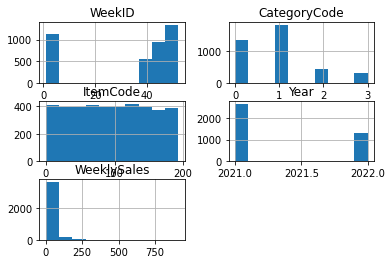

In [39]:
group_by_week.hist()
plt.show()

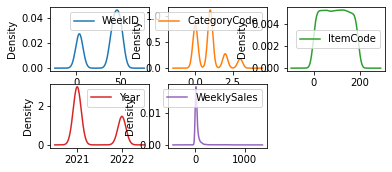

In [40]:
group_by_week.plot(kind='density', subplots=True, sharex=False, layout=(3, 3))
plt.show()

In [41]:
column_names = list(group_by_week.columns)
column_names

['WeekID', 'CategoryCode', 'ItemCode', 'Year', 'WeeklySales']

[Text(0.5, 1.0, 'Correlation matrix\n')]

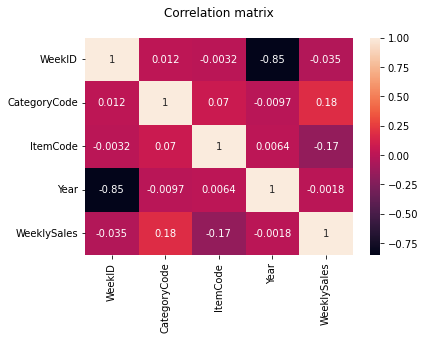

In [42]:
hm = sns.heatmap(group_by_week.corr(), annot = True)
hm.set(title = "Correlation matrix\n")

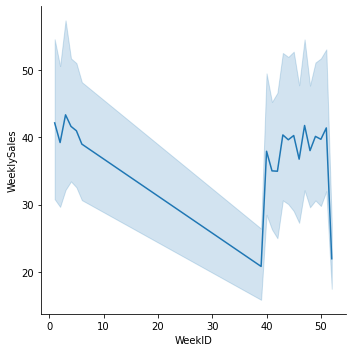

In [43]:
sns.relplot(x=group_by_week['WeekID'], y=group_by_week['WeeklySales'], kind='line')
plt.show()

In [44]:
# sns.regplot(x=group_by_week['MonthID'], y=group_by_week['DailySales'])

In [45]:
# sns.relplot(x=group_by_week['WeekIDofMonth'], y=group_by_week['DailySales'])

In [46]:
def normalize_daily_sales(count):
    return (32 - count) / 32

In [47]:
X = pd.DataFrame()
X['week_id_of_year'] = group_by_week['WeekID']
# X['week_id_of_month'] = group_by_week['WeekIDofMonth']
X['category_code'] = group_by_week['CategoryCode']
X['item_code'] = group_by_week['ItemCode']
# X['month_id'] = group_by_week['MonthID']

Y = pd.DataFrame()
Y = group_by_week['WeeklySales']

In [48]:
X.head()

,week_id_of_year,category_code,item_code
0,1,0,0
1,1,0,1
2,1,0,5
3,1,0,6
4,1,0,10


In [49]:
X.dtypes

week_id_of_year    int64
category_code      int64
item_code          int64
dtype: object

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

In [67]:
X_train.skew()

week_id_of_year   -0.837938
category_code      0.849152
item_code          0.012743
dtype: float64

# Random Forest Refgressor

In [68]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor().fit(X_train, Y_train)
reg.score(X_train, Y_train)

0.9642748115723399

In [69]:
predicted = reg.predict(X_test)

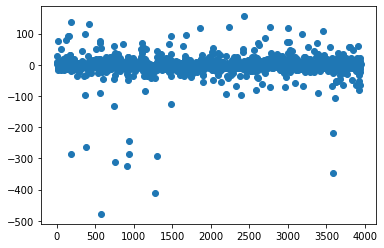

In [70]:
plt.plot(Y_test - predicted, marker='o', linestyle='')

# Extra Trees Regressor

In [71]:
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_test, Y_test)
reg.score(X_test, Y_test)

0.9957133899388722

In [72]:
predicted = reg.predict(X_test)

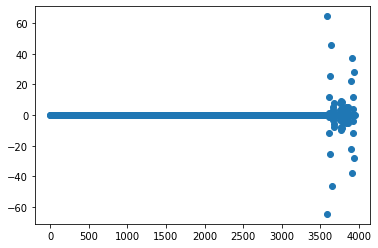

In [73]:
plt.plot(Y_test - predicted, marker='o', linestyle='')

# Bagging Regressor

# 